# Photon-Prediction IoU

## load data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import time
import pickle

2023-12-08 17:59:12.653580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 17:59:13.226244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load photons, distance indices of images and invalid indices
xz_icesat = np.load('../xz_icesat_new.npy')
ground = np.load('../ground_06_new.npy')

m_resolution = 64

# empty_subs = np.load('../data/ground/ML/Histogram_KDE/empty_all_128_1.npy')
# arr = np.load('../data/ground/ML/Histogram_KDE/it_array_all_128.npy')
# if empty_subs.shape[0] > 0:
#     arr = np.delete(arr, empty_subs)
# arr

empty_subs = np.load(f'../labelmaking/empty_all_scaled_{m_resolution}_1.npy')
arr = np.load(f'../labelmaking/it_array_all_scaled_{m_resolution}.npy')
if empty_subs.shape[0] > 0:
    arr = np.delete(arr, empty_subs)
print(arr)

ind_all = np.load(f'../labelmaking/all_concat_{m_resolution}_s5_indices.npy')

[    0     5    10 ... 30650 30655 30660]


## IoU loop

In [4]:
def iou_loop(m_resolution, px_resolution, lower, upper, stepsize, show_plot=False):
    start = time.time()
    resolution = m_resolution/px_resolution
    accuracy = []
    precision = []
    sensitivity = []
    specificity = []
    f1score = []
    iou = []
    
    TP_list_l = []
    FP_list_l = []
    FN_list_l = []
    TN_list_l = []
    
    # for each prediction image
    for i in np.arange(lower,upper,stepsize):
    #for i in np.arange(0,1,1):
        # set up the transform to (0,0)
        subset_in_xz, = np.where((xz_icesat[:,0] >= arr[i]) & (xz_icesat[:,0] < arr[i]+m_resolution))
        subset = xz_icesat[subset_in_xz]
        xr = int(subset[:,0].max()-(subset[:,0].max()-subset[:,0].min())/2)
        zr = int(subset[:,1].max()-(subset[:,1].max()-subset[:,1].min())/2)
    
        # ground photons
        ground_ii, = np.where((xz_icesat[ground,0] >= arr[i]) & (xz_icesat[ground,0] < arr[i]+m_resolution))
        ground_in_xz = ground[ground_ii]
        subset_g = xz_icesat[ground_in_xz]
        xg = (subset_g[:,0] - xr)/resolution
        zg = (subset_g[:,1] - zr)/resolution
        xz = np.round(np.c_[px_resolution-(zg+px_resolution/2),xg+px_resolution/2]).astype(int)
    
        # non-ground photons
        nonground = np.setxor1d(ground, np.arange(0,len(xz_icesat)))
        notground_in_xz = np.setxor1d(subset_in_xz, ground_in_xz)
        subset_ng = xz_icesat[notground_in_xz]
        xng = (subset_ng[:,0] - xr)/resolution
        zng = (subset_ng[:,1] - zr)/resolution
        xzn = np.round(np.c_[px_resolution-(zng+px_resolution/2),xng+px_resolution/2]).astype(int)
    
        # find photon-prediction overlap/intersection
        indlist_TP = []
        indlist_FP = []
        indlist_FN = []
        indlist_TN = []
        for j in np.arange(px_resolution):
            for k in range(px_resolution):
                if y_pred[i][j,k][0]:
                    # prediction is "Ground" and there is a ground photon as well
                    arr_ind_TP = np.where(np.equal([j,k], xz).all(axis=1) == True)[0]
                    if len(arr_ind_TP) > 0:
                        indlist_TP.append(arr_ind_TP)
                    # prediction is "Ground" but there is a not-ground photon
                    arr_ind_FP = np.where(np.equal([j,k], xzn).all(axis=1) == True)[0]
                    if len(arr_ind_FP) > 0:
                        indlist_FP.append(arr_ind_FP)
                else:
                    # prediction is "No Ground" but there is actually a ground photon
                    arr_ind_FN = np.where(np.equal([j,k], xz).all(axis=1) == True)[0]
                    if len(arr_ind_FN) > 0:
                        indlist_FN.append(arr_ind_FN)
                    # prediction is "No Ground" and there is a non-ground photon
                    arr_ind_TN = np.where(np.equal([j,k], xzn).all(axis=1) == True)[0]
                    if len(arr_ind_TN) > 0:
                        indlist_TN.append(arr_ind_TN)
                    
        # classes
        if len(indlist_TP) > 0:
            indlist_TP = np.unique(np.concatenate(indlist_TP))
            TP_list_l.append(ground_in_xz[indlist_TP])    
        else:
            indlist_TP = []
            TP_list_l.append(indlist_TP)
        #indlist_TP = np.unique(np.concatenate(indlist_TP))
        #TP_list.append(ground_in_xz[indlist_TP])
        
        if len(indlist_FP) > 0:
            indlist_FP = np.unique(np.concatenate(indlist_FP))
            FP_list_l.append(notground_in_xz[indlist_FP])    
        else:
            indlist_FP = []
            FP_list_l.append(indlist_FP)
        
        if len(indlist_FN) > 0:
            indlist_FN = np.unique(np.concatenate(indlist_FN))
            FN_list_l.append(ground_in_xz[indlist_FN])    
        else:
            indlist_FN = []
            FN_list_l.append(indlist_FN)
    
        if len(indlist_TN) > 0:
            indlist_TN = np.unique(np.concatenate(indlist_TN))
            TN_list_l.append(notground_in_xz[indlist_TN])    
        else:
            indlist_TN = []
            TN_list_l.append(indlist_TN)
    
        # metrics
        # accuracy
        if (len(indlist_TP) + len(indlist_TN) + len(indlist_FP) + len(indlist_FN)) > 0:
            accuracy.append((len(indlist_TP) + len(indlist_TN)) / (len(indlist_TP) + len(indlist_TN) + len(indlist_FP) + len(indlist_FN)) * 100)
        else:
            accuracy.append(0)
    
        # precision
        if (len(indlist_TP)+len(indlist_FP)) > 0:
            precision.append(len(indlist_TP) / (len(indlist_TP)+len(indlist_FP)) * 100)
        else:
            precision.append(0)
    
        # sensitivity
        if (len(indlist_TP)+len(indlist_FN)) > 0:
            sensitivity.append(len(indlist_TP) / (len(indlist_TP)+len(indlist_FN)) * 100)
        else:
            sensitivity.append(0)
    
        # specificity
        if (len(indlist_TN)+len(indlist_FP)) > 0:
            specificity.append(len(indlist_TN) / (len(indlist_TN)+len(indlist_FP)) * 100)
        else:
            specificity.append(0)
    
        # f1 score
        if ((len(indlist_TP)) + len(indlist_FP) + len(indlist_FN)) > 0:
            f1score.append((2*len(indlist_TP)) / (2*(len(indlist_TP)) + len(indlist_FP) + len(indlist_FN)) * 100)
        else:
            f1score.append(0)

        # IoU
        if (len(indlist_TP)+len(indlist_FP)+len(indlist_FN)) > 0:
            iou.append(len(indlist_TP) / (len(indlist_TP)+len(indlist_FP)+len(indlist_FN)) * 100)
        else:
            iou.append(0)

        if show_plot==True:
            # plot
            fig, ax = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
            ax[0].imshow(y_pred[i], extent=(0, 128, 128, 0))
            ax[0].scatter(xg+px_resolution/2,px_resolution-(zg+px_resolution/2), s=1, label='ground');
            ax[0].scatter(xng+px_resolution/2,px_resolution-(zng+px_resolution/2), s=1, label='non-ground');
            ax[0].set_yticklabels(np.arange(0, px_resolution, 8), fontsize=8)
            ax[0].yaxis.set_ticks(np.arange(0, px_resolution, 8))
            ax[0].set_xticklabels(np.arange(0, px_resolution+8, 8), fontsize=8)
            ax[0].xaxis.set_ticks(np.arange(0, px_resolution, 8))
            ax[0].grid(which='major', alpha=0.3)
            ax[0].legend()
            if len(indlist_TP) > 0:
                ax[1].scatter(*zip(*xz_icesat[ground_in_xz[indlist_TP]]), s=2, label='TP') # true ground (ground in prediction)
            if len(indlist_FN) > 0:
                ax[1].scatter(*zip(*xz_icesat[ground_in_xz[indlist_FN]]), s=5, label='FN', c='tab:orange') # ground outside of prediction
            if len(indlist_FP) > 0:
                ax[1].scatter(*zip(*xz_icesat[notground_in_xz[indlist_FP]]), s=5, label='FP', c='tab:green') # nonground inside in prediction
            if len(indlist_TN) > 0:
                ax[1].scatter(*zip(*xz_icesat[notground_in_xz[indlist_TN]]), s=2, label='TN', c='tab:red') # nonground outside of prediction
            ax[1].set_xlim(subset[:,0].min(),subset[:,0].max());
            ax[1].set_ylim(zr-m_resolution/2,zr+m_resolution/2);
            ax[1].set_xlabel('Alongtrack distance [m]')
            ax[1].set_ylabel('Elevation [m]')
            ax[1].yaxis.set_label_position("right")
            ax[1].yaxis.tick_right()
            ax[1].set_aspect(1);
            ax[1].grid();
            ax[1].legend();
    
    accuracy_l    = np.asarray(accuracy)
    precision_l   = np.asarray(precision)
    sensitivity_l = np.asarray(sensitivity)
    specificity_l = np.asarray(specificity)
    f1score_l     = np.asarray(f1score)
    iou_l         = np.asarray(iou)
    
    end = time.time()
    print(f'Runtime: {end - start:.1f} s')
    return TP_list_l, TN_list_l, FP_list_l, FN_list_l, accuracy_l, precision_l, sensitivity_l, specificity_l, f1score_l, iou_l

## load prediction images

In [21]:
# load predicted images

data = np.load('all_predicted_scaled_squared_EDT2_res64_order.npz')

y_pred = data['pred']


### run

/tmp/ipykernel_1539610/2207438254.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(np.arange(0, px_resolution, 8), fontsize=8)
/tmp/ipykernel_1539610/2207438254.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(0, px_resolution+8, 8), fontsize=8)


Runtime: 0.3 s
80.00, 79.19, 99.16, 24.39, 88.06, 78.67


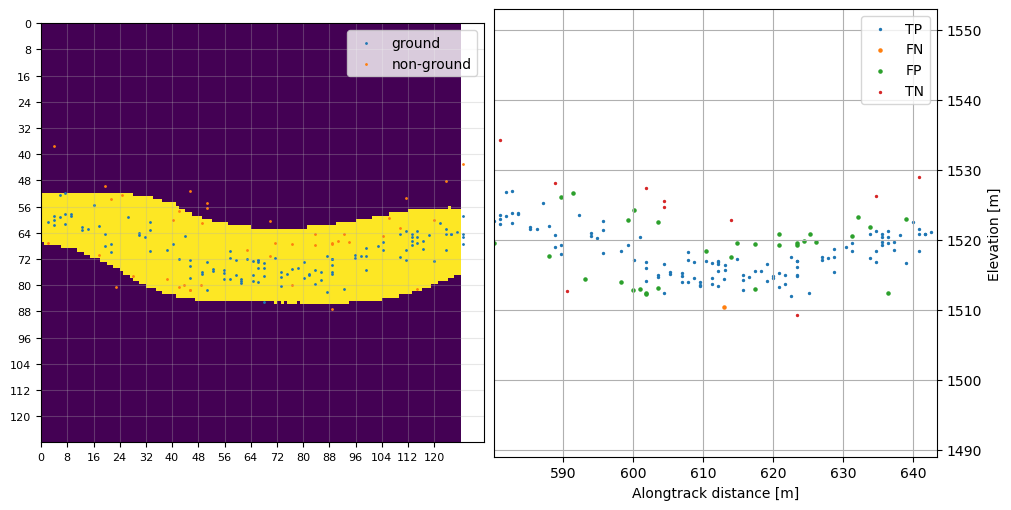

In [182]:
val = 110
_,_,_,_,acc,prec,sens,spec,f1s,iou = iou_loop(64, 128, val, val+1, 1, show_plot=True)
plt.savefig('mtns_kde0.png', dpi=300, bbox_inches='tight', transparent=True)

print(f"{acc[0]:.2f}, {prec[0]:.2f}, {sens[0]:.2f}, {spec[0]:.2f}, {f1s[0]:.2f}, {iou[0]:.2f}")

/tmp/ipykernel_1539610/2207438254.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(np.arange(0, px_resolution, 8), fontsize=8)
/tmp/ipykernel_1539610/2207438254.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(0, px_resolution+8, 8), fontsize=8)


Runtime: 0.3 s
75.51, 73.91, 100.00, 20.00, 85.00, 73.91


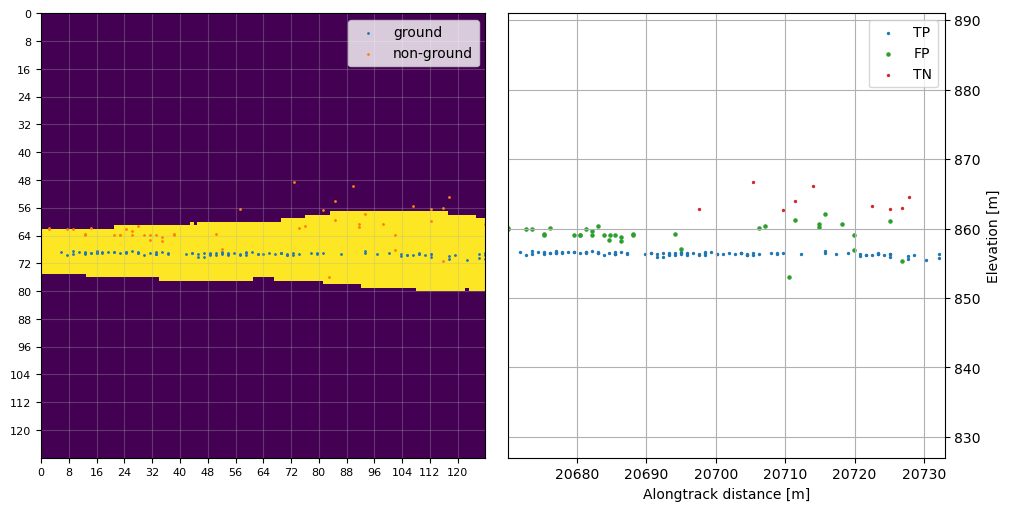

In [183]:
_,_,_,_,acc,prec,sens,spec,f1s,iou = iou_loop(64, 128, 4090, 4091, 1, show_plot=True)
plt.savefig('flat_kde0.png', dpi=300, bbox_inches='tight', transparent=True)
print(f"{acc[0]:.2f}, {prec[0]:.2f}, {sens[0]:.2f}, {spec[0]:.2f}, {f1s[0]:.2f}, {iou[0]:.2f}")

In [32]:
for i in np.arange(2,4):
    data = np.load(f'all_predicted_comb_scaled_EDT{i}_res64_order.npz')
    y_pred = data['pred']

    TP_list, TN_list, FP_list, FN_list, accuracy, precision, sensitivity, specificity, f1score, iou = iou_loop(64, 128, 0, len(arr), 5, show_plot=False)

    l = 'n'
    extra = 'comb_scaled'
    u = 5
    res = 64
    edtv = i
    with open(f"TP_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:   
        pickle.dump(TP_list, fp)
    with open(f"FP_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:
        pickle.dump(FP_list, fp)
    with open(f"FN_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:   
        pickle.dump(FN_list, fp)
    with open(f"TN_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:   
        pickle.dump(TN_list, fp)

    np.save(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', accuracy)
    np.save(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', precision)
    np.save(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', sensitivity)
    np.save(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', specificity)
    np.save(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', f1score)
    np.save(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', iou)

    print(f'EDT{i} done')

Runtime: 323.8 s
EDT2 done
Runtime: 322.8 s
EDT3 done


In [6]:
TP_list, TN_list, FP_list, FN_list, accuracy, precision, sensitivity, specificity, f1score, iou = iou_loop(64, 128, 0, len(arr), 1, show_plot=False)

Runtime: 1746.7 s


## save results

### IoU classes

In [7]:
l = 'n'
extra = 'scaled_squared'
u = 1
res = 64
edtv = 2
with open(f"TP_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:   
    pickle.dump(TP_list, fp)
with open(f"FP_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:
    pickle.dump(FP_list, fp)
with open(f"FN_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:   
    pickle.dump(FN_list, fp)
with open(f"TN_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "wb") as fp:   
    pickle.dump(TN_list, fp)

### metrics

In [8]:
np.save(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', accuracy)
np.save(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', precision)
np.save(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', sensitivity)
np.save(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', specificity)
np.save(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', f1score)
np.save(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy', iou)


## load results

### IoU classes

In [2]:
l = 'n'
extra = 'scaled_squared'
u = 1
res = 64
edtv = 2

with open(f"TP_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "rb") as fp:
    TP_list = pickle.load(fp)
with open(f"FP_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "rb") as fp:
    FP_list = pickle.load(fp)
with open(f"FN_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "rb") as fp:
    FN_list = pickle.load(fp)
with open(f"TN_list_{extra}_r{res}_EDT{edtv}_{l}_{u}", "rb") as fp:
    TN_list = pickle.load(fp)

### metrics

In [8]:
accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )

In [9]:
print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
print(f'Average precision:   {np.nanmean(precision):.2f} %')
print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
print(f'Average specificity: {np.nanmean(specificity):.2f} %')
print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

Average accuracy:    93.37 %
Average precision:   93.59 %
Average sensitivity: 97.39 %
Average specificity: 62.57 %
Average f1score:     95.25 %
Average IoU:         91.47 %



## results of best model

In [3]:
# concatenate image-wise indices
TP_arr = np.concatenate(TP_list)
FP_arr = np.concatenate(FP_list)
FN_arr = np.concatenate(FN_list)
TN_arr = np.concatenate(TN_list)

# find unique indices in every class
TP_unique, TP_counts = np.unique(TP_arr, return_counts=True)
FN_unique, FN_counts = np.unique(FN_arr, return_counts=True)
TN_unique, TN_counts = np.unique(TN_arr, return_counts=True)
FP_unique, FP_counts = np.unique(FP_arr, return_counts=True)

FN_unique = FN_unique.astype(int)
TN_unique = TN_unique.astype(int)
FP_unique = FP_unique.astype(int)

# find indices that occur in more than class
TPFN, ii_TP, ii_FN = np.intersect1d(TP_unique,FN_unique, return_indices=True)
TNFP, ii_TN, ii_FP = np.intersect1d(TN_unique,FP_unique, return_indices=True)

print(f'No of TP photons: {len(TP_unique)}')
print(f'No of FN photons: {len(FN_unique)}')
print(f'No of photons both in TP and FN: {len(TPFN)}')
print(f'No of TN photons: {len(TN_unique)}')
print(f'No of FP photons: {len(FP_unique)}')
print(f'No of photons both in TN and FP: {len(TNFP)}')

No of TP photons: 59695
No of FN photons: 4155
No of photons both in TP and FN: 3848
No of TN photons: 11015
No of FP photons: 6453
No of photons both in TN and FP: 4359


In [17]:
# total number of photons
59695+4155-3848+11015+6453-4359

73111

In [4]:
true_TP = np.delete(TP_unique, ii_TP)
true_FN = np.delete(FN_unique, ii_FN)
true_TN = np.delete(TN_unique, ii_TN)
true_FP = np.delete(FP_unique, ii_FP)

print(f'No of true TP photons: {len(true_TP)}')
print(f'No of true FN photons: {len(true_FN)}')
print(f'No of true TN photons: {len(true_TN)}')
print(f'No of true FP photons: {len(true_FP)}')

No of true TP photons: 55847
No of true FN photons: 307
No of true TN photons: 6656
No of true FP photons: 2094


In [5]:
# indices in TP_counts[ii_TP] that are TP after all
TP_subii2 = np.where(TP_counts[ii_TP] >= 7)[0]
# indices in photons that are TP after all
true_TP2 = TPFN[TP_subii2]

# concatenate first and second choice TP
TP_indices = np.concatenate((true_TP, true_TP2))
print(len(TP_indices))

# all indices of TPFN that are not in TP_subii2 are designated to FN
FN_subii2 = np.setxor1d(np.arange(0,len(TPFN)),TP_subii2)
# indices in photons that are TP after all
true_FN2 = TNFP[FN_subii2]

# concatenate first and second choice FN
FN_indices = np.concatenate((true_FN, true_FN2))
print(len(FN_indices))

# check if every TP/FN photon covered:
len(TPFN) == len(true_TP2)+len(true_FN2)

58722
1280


True

In [6]:
# indices in TN_counts[ii_TN] that are TN after all
TN_subii2 = np.where(TN_counts[ii_TN] >= 7)[0]
# indices in photons that are TP after all
true_TN2 = TNFP[TN_subii2]

# concatenate first and second choice TN
TN_indices = np.concatenate((true_TN, true_TN2))
print(len(TN_indices))

# all indices of TPFN that are not in TN_subii2 are designated to FP
FP_subii2 = np.setxor1d(np.arange(0,len(TNFP)),TN_subii2)
# indices in photons that are TP after all
true_FP2 = TNFP[FP_subii2]

# concatenate first and second choice FP
FP_indices = np.concatenate((true_FP, true_FP2))
print(len(FP_indices))

# check if every TN/FP photon covered:
len(TNFP) == len(true_TN2)+len(true_FP2)

9596
3513


True

In [34]:
# number of ground indices
print(len(TP_indices)+len(FP_indices))

62235


In [35]:
# save ground indices
ground_ML = np.concatenate((TP_indices, FP_indices))
np.save('ground_ML.npy',ground_ML)

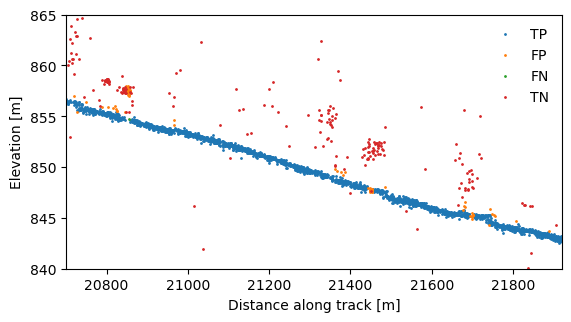

In [18]:
fig, ax = plt.subplots()
#fig.set_dpi(200)
#ax.scatter(xz_icesat[:,0],xz_icesat[:,1], c='k', s=1, label='ICESat-2 photons');
ax.scatter(xz_icesat[TP_indices,0],xz_icesat[TP_indices,1], c='tab:blue', s=1, label='TP');
ax.scatter(xz_icesat[FP_indices,0],xz_icesat[FP_indices,1], c='tab:orange', s=1, label='FP');
ax.scatter(xz_icesat[FN_indices,0],xz_icesat[FN_indices,1], c='tab:green', s=1, label='FN');
ax.scatter(xz_icesat[TN_indices,0],xz_icesat[TN_indices,1], c='tab:red', s=1, label='TN');
ax.legend(frameon=False)
ax.set_xlim(20700,21920)
ax.set_ylim(840,865)
ax.set_aspect(25)
#ax.grid()
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]');
#plt.savefig('ground_scene_unet.png', dpi=300, bbox_inches='tight', transparent=True)

In [7]:
np.save('TP_indices.npy',TP_indices)
np.save('TN_indices.npy',TN_indices)
np.save('FP_indices.npy',FP_indices)
np.save('FN_indices.npy',FN_indices)

## averages

In [76]:
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

u = 5
res = 64
l = 'n'

for i in np.arange(2,4):
    edtv = i
    
    extra = 'scaled'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    
    extra = 'scaled_squared'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    extra = 'scaled_binary'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    extra = 'scaled_squared_binary'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

In [20]:
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

u = 5
res = 64

for i in np.arange(0,3):    
    names = ['KDE_r64_EDT0_n_5', 'KDE_edtlabel_r64_EDT2_n_5', 'KDE_edtlabel_r64_EDT3_n_5']
    
    acc.append(np.nanmean(np.load(f'accuracy_{names[i]}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{names[i]}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{names[i]}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{names[i]}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{names[i]}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{names[i]}.npy')))
    
    

In [22]:
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

u = 5
res = 64
l = 'n'

for i in np.arange(2,4):
    edtv = i
    
    extra = 'comb_scaled'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    
    extra = 'comb_scaled_squared'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    extra = 'comb_scaled_binary'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    extra = 'comb_scaled_squared_binary'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

In [78]:
print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
print(f'Average precision:   {np.nanmean(prec):.2f} %')
print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
print(f'Average specificity: {np.nanmean(spec):.2f} %')
print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

Average accuracy:    90.54 %
Average precision:   91.20 %
Average sensitivity: 96.70 %
Average specificity: 51.34 %
Average f1score:     93.54 %
Average IoU:         88.58 %



2
Average accuracy:    91.55 %
Average precision:   92.48 %
Average sensitivity: 96.35 %
Average specificity: 57.80 %
Average f1score:     94.12 %
Average IoU:         89.50 %

3
Average accuracy:    89.54 %
Average precision:   89.93 %
Average sensitivity: 97.05 %
Average specificity: 44.88 %
Average f1score:     92.95 %
Average IoU:         87.66 %

4
Average accuracy:    89.01 %
Average precision:   89.23 %
Average sensitivity: 97.32 %
Average specificity: 40.22 %
Average f1score:     92.65 %
Average IoU:         87.16 %

5
Average accuracy:    87.39 %
Average precision:   87.52 %
Average sensitivity: 97.67 %
Average specificity: 32.13 %
Average f1score:     91.73 %
Average IoU:         85.78 %



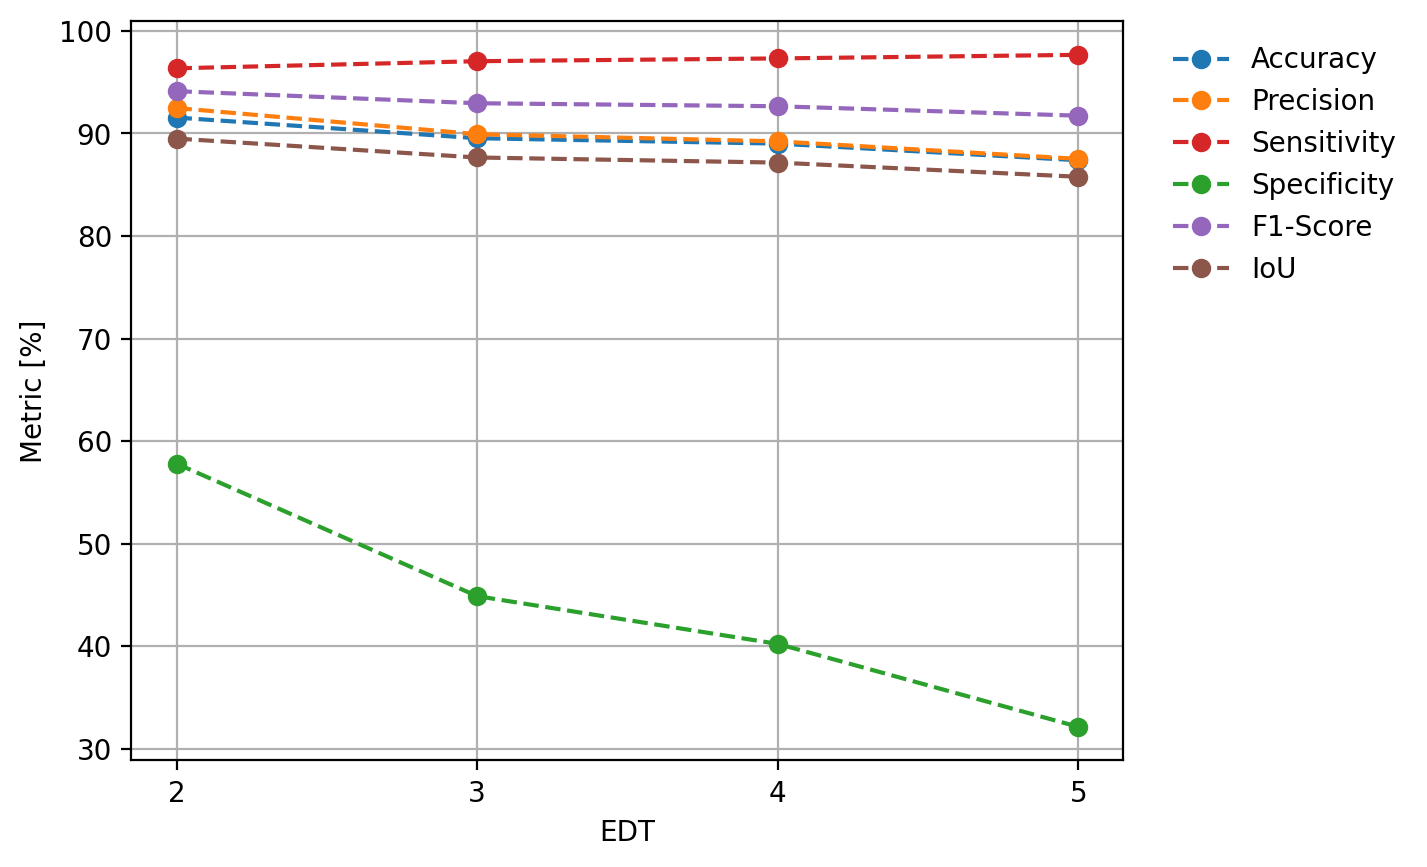

In [199]:
acc2 = []
prec2 = []
sens2 = []
spec2 = []
f1sc2 = []
iouu2 = []


u = 5
res = 64
l = 'n'

for i in np.arange(2,6):
    print(i)
    acc = []
    prec = []
    sens = []
    spec = []
    f1sc = []
    iouu = []

    edtv = i
    
    extra = 'scaled'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    
    extra = 'scaled_squared'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    extra = 'scaled_binary'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    extra = 'scaled_squared_binary'
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

    acc2.append(np.nanmean(acc))
    prec2.append(np.nanmean(prec))
    sens2.append(np.nanmean(sens))
    spec2.append(np.nanmean(spec))
    f1sc2.append(np.nanmean(f1sc))
    iouu2.append(np.nanmean(iouu))

fig, ax = plt.subplots()
fig.set_dpi(200)

ax.plot(np.arange(0,4), acc2, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(0,4), prec2, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(0,4), sens2, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(0,4), spec2, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(0,4), f1sc2, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(0,4), iouu2, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.set_xticks(np.arange(0,4), [2,3,4,5])
ax.grid();
#plt.savefig('metrics_edt_vals.png', dpi=300, bbox_inches='tight', transparent=True)

In [5]:
u = 5
res = 64
l = 'n'

acc2 = []
prec2 = []
sens2 = []
spec2 = []
f1sc2 = []
iouu2 = []

for i in np.arange(0,3):
    k = np.arange(0,6,2)[i]
    indices = np.arange(ind_all[k]//5,ind_all[k+2]//5)

    acc = []
    prec = []
    sens = []
    spec = []
    f1sc = []
    iouu = []
    
    for j in np.arange(2,3):
        edtv = j
        extra = 'scaled'
        acc.append(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices])
        prec.append((np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        sens.append((np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        spec.append((np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        f1sc.append((np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        iouu.append((np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

        extra = 'scaled_squared'
        acc.append(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices])
        prec.append((np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        sens.append((np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        spec.append((np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        f1sc.append((np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        iouu.append((np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

        extra = 'scaled_binary'
        acc.append(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices])
        prec.append((np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        sens.append((np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        spec.append((np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        f1sc.append((np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        iouu.append((np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

        extra = 'scaled_squared_binary'
        acc.append(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices])
        prec.append((np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        sens.append((np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        spec.append((np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        f1sc.append((np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
        iouu.append((np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

    acc2.append(np.nanmean(acc))
    prec2.append(np.nanmean(prec))
    sens2.append(np.nanmean(sens))
    spec2.append(np.nanmean(spec))
    f1sc2.append(np.nanmean(f1sc))
    iouu2.append(np.nanmean(iouu))
    print(f'Average accuracy:    {(acc2[i]):.2f} %')
    print(f'Average precision:   {(prec2[i]):.2f} %')
    print(f'Average sensitivity: {(sens2[i]):.2f} %')
    print(f'Average specificity: {(spec2[i]):.2f} %')
    print(f'Average f1score:     {(f1sc2[i]):.2f} %')
    print(f'Average IoU:         {(iouu2[i]):.2f} %\n')

Average accuracy:    87.92 %
Average precision:   88.20 %
Average sensitivity: 94.91 %
Average specificity: 68.17 %
Average f1score:     91.04 %
Average IoU:         84.25 %

Average accuracy:    94.27 %
Average precision:   95.99 %
Average sensitivity: 97.57 %
Average specificity: 48.14 %
Average f1score:     96.69 %
Average IoU:         93.77 %

Average accuracy:    95.82 %
Average precision:   97.40 %
Average sensitivity: 98.00 %
Average specificity: 46.42 %
Average f1score:     97.65 %
Average IoU:         95.53 %



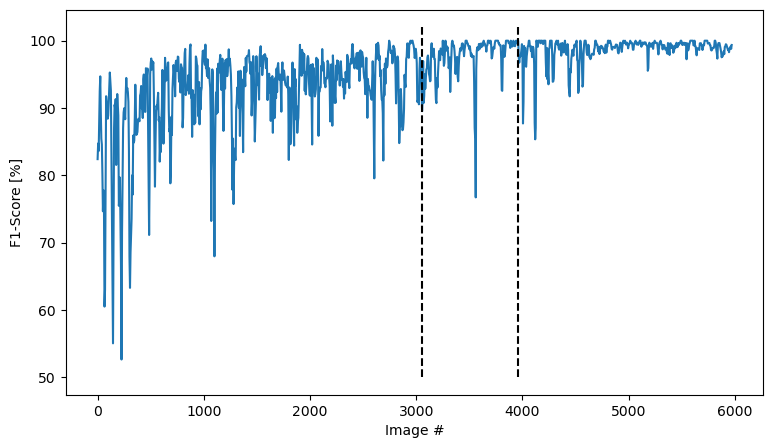

In [23]:
fig, ax = plt.subplots(figsize=(9,5))
extra = 'scaled_squared'
edtv = 2
u = 5
ax.plot(np.arange(0,len(y_pred),5), np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy'), c='tab:blue')
ax.vlines(ind_all[2], 50, 102, color='k', ls='--');
ax.vlines(ind_all[4], 50, 102, color='k', ls='--');
ax.set_ylabel('F1-Score [%]');
ax.set_xlabel('Image #');
plt.savefig('F1S_SS2.png', dpi=300, bbox_inches='tight', transparent=True)

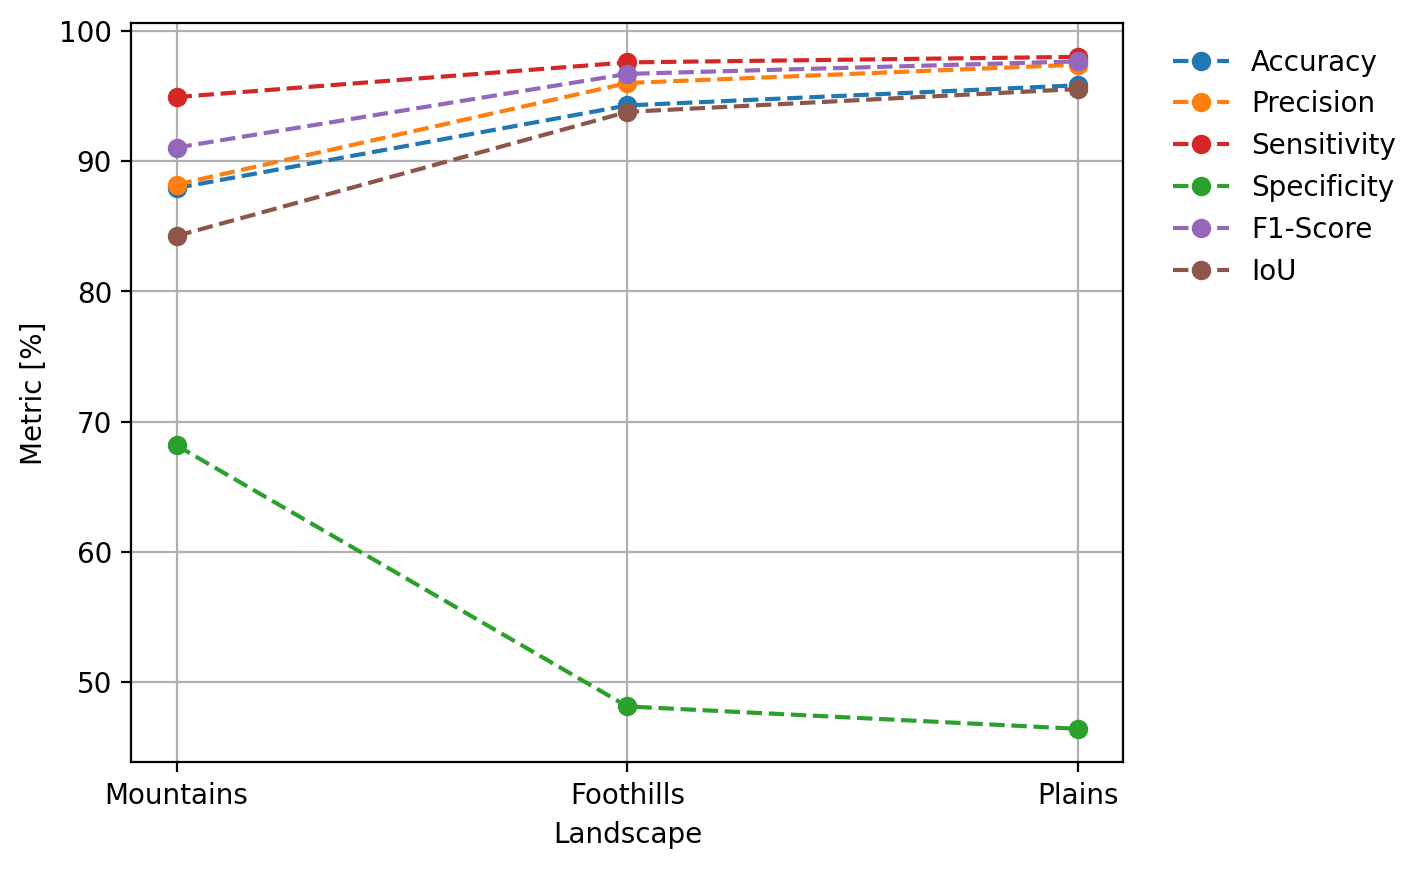

In [201]:
fig, ax = plt.subplots()
fig.set_dpi(200)

ax.plot(np.arange(0,3), acc2, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(0,3), prec2, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(0,3), sens2, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(0,3), spec2, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(0,3), f1sc2, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(0,3), iouu2, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('Landscape')
ax.set_ylabel('Metric [%]');
ax.set_xticks(np.arange(0,3), ['Mountains', 'Foothills', 'Plains'])
ax.grid();
plt.savefig('metrics_landscapes.png', dpi=300, bbox_inches='tight', transparent=True)

In [43]:
indices = np.arange(ind_all[0]//5,ind_all[2]//5)

acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

u = 5
res = 64
l = 'n'

extra = 'scaled'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_squared'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')
    
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_binary'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')
    
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_squared_binary'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

scaled
2
Average accuracy:    88.25 %
Average precision:   86.76 %
Average sensitivity: 97.59 %
Average specificity: 64.01 %
Average f1score:     91.39 %
Average IoU:         84.90 %

3
Average accuracy:    88.25 %
Average precision:   86.45 %
Average sensitivity: 98.02 %
Average specificity: 61.02 %
Average f1score:     91.44 %
Average IoU:         84.98 %

scaled_squared
2
Average accuracy:    89.58 %
Average precision:   89.85 %
Average sensitivity: 95.36 %
Average specificity: 73.04 %
Average f1score:     92.19 %
Average IoU:         86.13 %

3
Average accuracy:    88.55 %
Average precision:   87.71 %
Average sensitivity: 96.75 %
Average specificity: 63.69 %
Average f1score:     91.62 %
Average IoU:         85.20 %

scaled_binary
2
Average accuracy:    86.99 %
Average precision:   87.87 %
Average sensitivity: 93.77 %
Average specificity: 66.06 %
Average f1score:     90.37 %
Average IoU:         83.15 %

3
Average accuracy:    84.21 %
Average precision:   84.69 %
Average sensitivity

In [48]:
indices = np.arange(ind_all[2]//5,ind_all[4]//5)

acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

u = 5
res = 64
l = 'n'

extra = 'scaled'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_squared'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')
    
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_binary'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')
    
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_squared_binary'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

scaled
2
Average accuracy:    95.65 %
Average precision:   95.96 %
Average sensitivity: 99.23 %
Average specificity: 48.21 %
Average f1score:     97.47 %
Average IoU:         95.26 %

3
Average accuracy:    95.52 %
Average precision:   95.56 %
Average sensitivity: 99.53 %
Average specificity: 42.64 %
Average f1score:     97.42 %
Average IoU:         95.15 %

scaled_squared
2
Average accuracy:    96.13 %
Average precision:   96.46 %
Average sensitivity: 99.16 %
Average specificity: 53.00 %
Average f1score:     97.73 %
Average IoU:         95.72 %

3
Average accuracy:    95.53 %
Average precision:   95.60 %
Average sensitivity: 99.52 %
Average specificity: 44.45 %
Average f1score:     97.41 %
Average IoU:         95.19 %

scaled_binary
2
Average accuracy:    92.65 %
Average precision:   95.66 %
Average sensitivity: 96.11 %
Average specificity: 44.07 %
Average f1score:     95.80 %
Average IoU:         92.09 %

3
Average accuracy:    91.78 %
Average precision:   94.81 %
Average sensitivity

In [49]:
indices = np.arange(ind_all[4]//5,ind_all[6]//5)

acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

u = 5
res = 64
l = 'n'

extra = 'scaled'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_squared'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')
    
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_binary'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')
    
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

extra = 'scaled_squared_binary'
print(extra)
for i in np.arange(2,4):
    edtv = i
    print(i)
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')[indices]))

    print(f'Average accuracy:    {np.nanmean(acc):.2f} %')
    print(f'Average precision:   {np.nanmean(prec):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sens):.2f} %')
    print(f'Average specificity: {np.nanmean(spec):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1sc):.2f} %')
    print(f'Average IoU:         {np.nanmean(iouu):.2f} %\n')

scaled
2
Average accuracy:    97.26 %
Average precision:   97.29 %
Average sensitivity: 99.72 %
Average specificity: 46.61 %
Average f1score:     98.43 %
Average IoU:         97.03 %

3
Average accuracy:    97.25 %
Average precision:   97.18 %
Average sensitivity: 99.82 %
Average specificity: 42.34 %
Average f1score:     98.43 %
Average IoU:         97.02 %

scaled_squared
2
Average accuracy:    97.75 %
Average precision:   97.86 %
Average sensitivity: 99.65 %
Average specificity: 49.35 %
Average f1score:     98.72 %
Average IoU:         97.53 %

3
Average accuracy:    97.45 %
Average precision:   97.43 %
Average sensitivity: 99.77 %
Average specificity: 43.57 %
Average f1score:     98.55 %
Average IoU:         97.23 %

scaled_binary
2
Average accuracy:    94.19 %
Average precision:   97.25 %
Average sensitivity: 96.32 %
Average specificity: 43.32 %
Average f1score:     96.75 %
Average IoU:         93.83 %

3
Average accuracy:    93.77 %
Average precision:   96.89 %
Average sensitivity

## visualize

### scaled

In [102]:
print('scaled only')
for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

scaled only
EDT = 2
Average accuracy:    92.42 %
Average precision:   91.71 %
Average sensitivity: 98.55 %
Average specificity: 55.75 %
Average f1score:     94.69 %
Average IoU:         90.56 %

EDT = 3
Average accuracy:    92.36 %
Average precision:   91.19 %
Average sensitivity: 99.16 %
Average specificity: 48.11 %
Average f1score:     94.72 %
Average IoU:         90.60 %

EDT = 4
Average accuracy:    90.68 %
Average precision:   89.66 %
Average sensitivity: 98.87 %
Average specificity: 40.46 %
Average f1score:     93.67 %
Average IoU:         88.88 %

EDT = 5
Average accuracy:    89.12 %
Average precision:   88.24 %
Average sensitivity: 98.94 %
Average specificity: 34.98 %
Average f1score:     92.73 %
Average IoU:         87.49 %



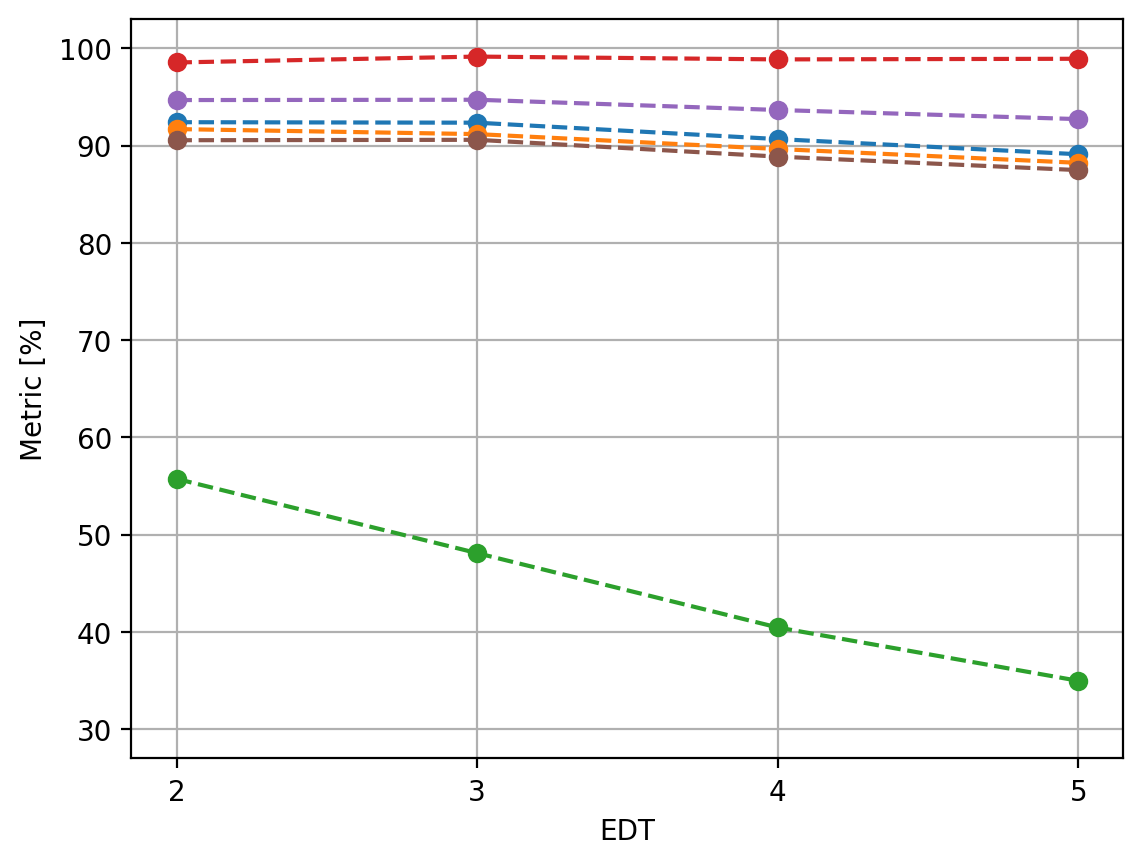

In [6]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,6), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,6), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,6), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,6), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,6), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,6), iouu, '--o', color='tab:brown', label='IoU');
#ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3,4,5]);
ax.set_ylim(27,103);
plt.savefig('metrics_scaled.png', dpi=300, bbox_inches='tight', transparent=True)

### squared

In [103]:
print('scaled and squared')
for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled_squared'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

scaled and squared
EDT = 2
Average accuracy:    93.33 %
Average precision:   93.55 %
Average sensitivity: 97.38 %
Average specificity: 62.01 %
Average f1score:     95.23 %
Average IoU:         91.43 %

EDT = 3
Average accuracy:    91.89 %
Average precision:   90.82 %
Average sensitivity: 99.00 %
Average specificity: 45.96 %
Average f1score:     94.44 %
Average IoU:         90.11 %

EDT = 4
Average accuracy:    89.02 %
Average precision:   88.30 %
Average sensitivity: 98.79 %
Average specificity: 35.76 %
Average f1score:     92.69 %
Average IoU:         87.42 %

EDT = 5
Average accuracy:    88.72 %
Average precision:   87.46 %
Average sensitivity: 99.68 %
Average specificity: 30.34 %
Average f1score:     92.59 %
Average IoU:         87.25 %



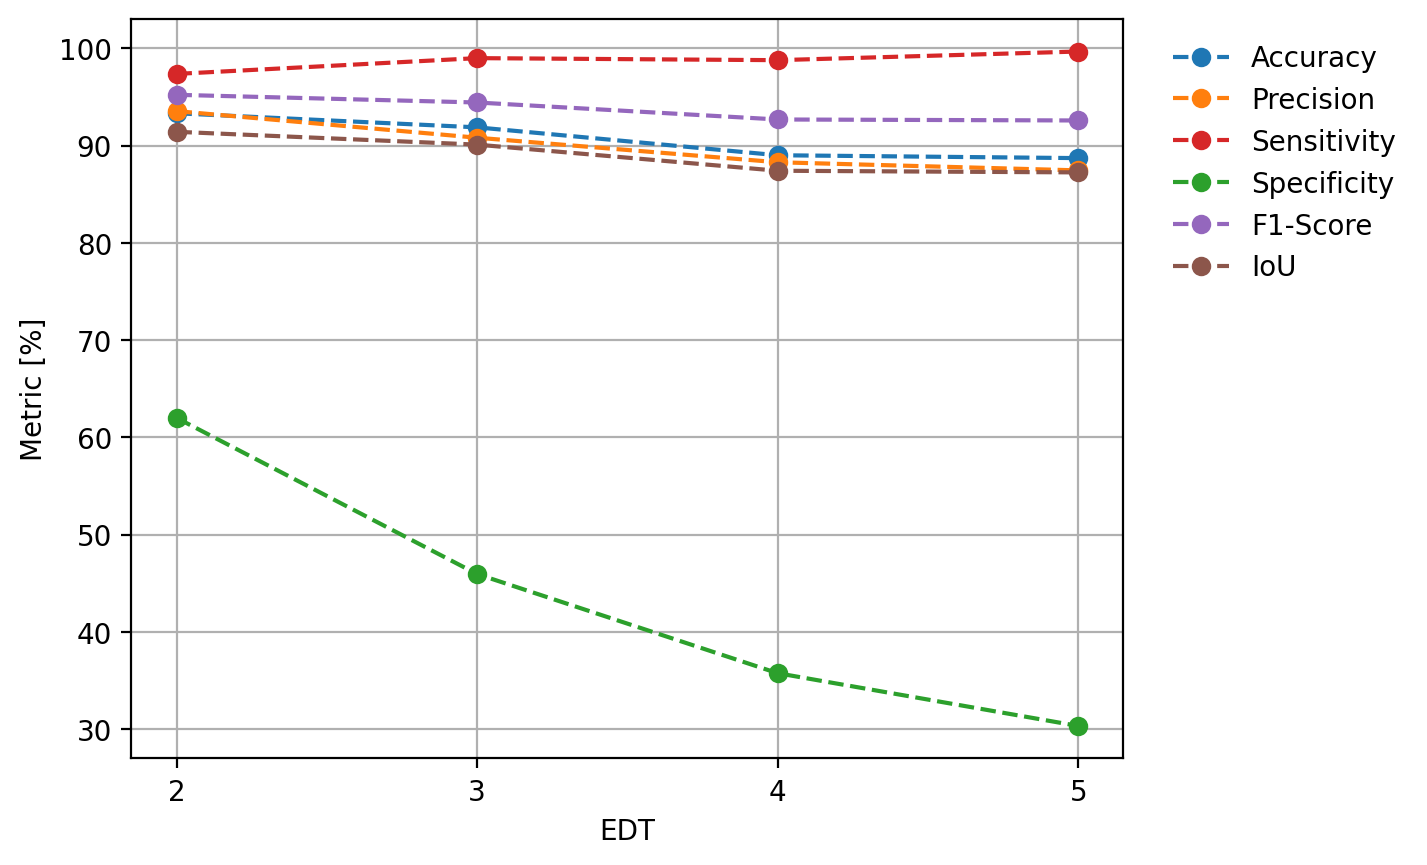

In [7]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled_squared'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,6), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,6), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,6), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,6), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,6), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,6), iouu, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3,4,5]);
ax.set_ylim(27,103);
plt.savefig('metrics_scaled_squared.png', dpi=300, bbox_inches='tight', transparent=True)

### binary operation on label

In [104]:
print('scaled, label')
for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled_binary'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

scaled, label
EDT = 2
Average accuracy:    90.28 %
Average precision:   92.21 %
Average sensitivity: 94.99 %
Average specificity: 55.07 %
Average f1score:     93.35 %
Average IoU:         88.11 %

EDT = 3
Average accuracy:    86.88 %
Average precision:   88.46 %
Average sensitivity: 95.51 %
Average specificity: 40.40 %
Average f1score:     91.35 %
Average IoU:         84.99 %

EDT = 4
Average accuracy:    88.19 %
Average precision:   89.45 %
Average sensitivity: 95.86 %
Average specificity: 42.00 %
Average f1score:     92.14 %
Average IoU:         86.18 %

EDT = 5
Average accuracy:    86.67 %
Average precision:   87.86 %
Average sensitivity: 96.15 %
Average specificity: 34.34 %
Average f1score:     91.29 %
Average IoU:         84.89 %



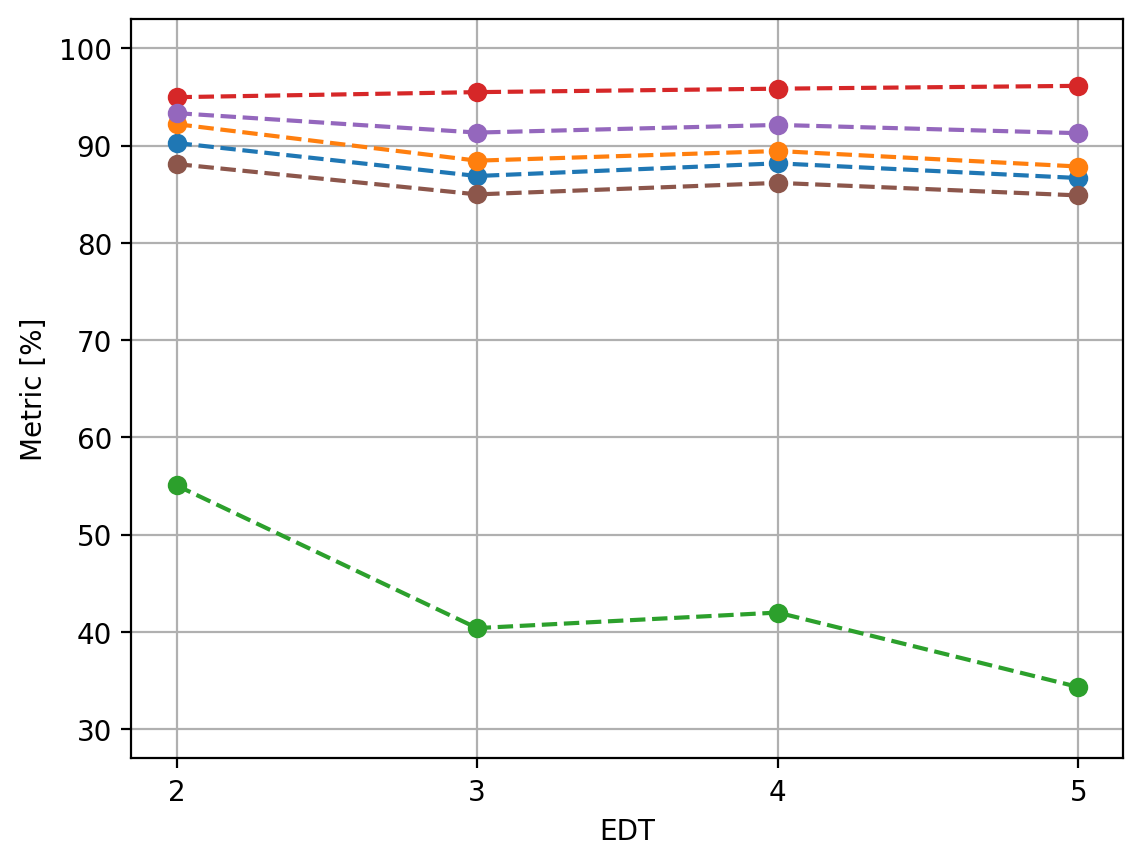

In [8]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled_binary'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,6), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,6), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,6), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,6), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,6), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,6), iouu, '--o', color='tab:brown', label='IoU');
#ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3,4,5]);
ax.set_ylim(27,103);
plt.savefig('metrics_scaled_bin.png', dpi=300, bbox_inches='tight', transparent=True)

In [105]:
print('scaled, squared, label')
for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled_squared_binary'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

scaled, squared, label
EDT = 2
Average accuracy:    90.17 %
Average precision:   92.45 %
Average sensitivity: 94.49 %
Average specificity: 58.38 %
Average f1score:     93.22 %
Average IoU:         87.90 %

EDT = 3
Average accuracy:    87.01 %
Average precision:   89.24 %
Average sensitivity: 94.52 %
Average specificity: 45.04 %
Average f1score:     91.28 %
Average IoU:         84.92 %

EDT = 4
Average accuracy:    88.15 %
Average precision:   89.51 %
Average sensitivity: 95.75 %
Average specificity: 42.65 %
Average f1score:     92.11 %
Average IoU:         86.15 %

EDT = 5
Average accuracy:    85.03 %
Average precision:   86.53 %
Average sensitivity: 95.90 %
Average specificity: 28.86 %
Average f1score:     90.32 %
Average IoU:         83.48 %



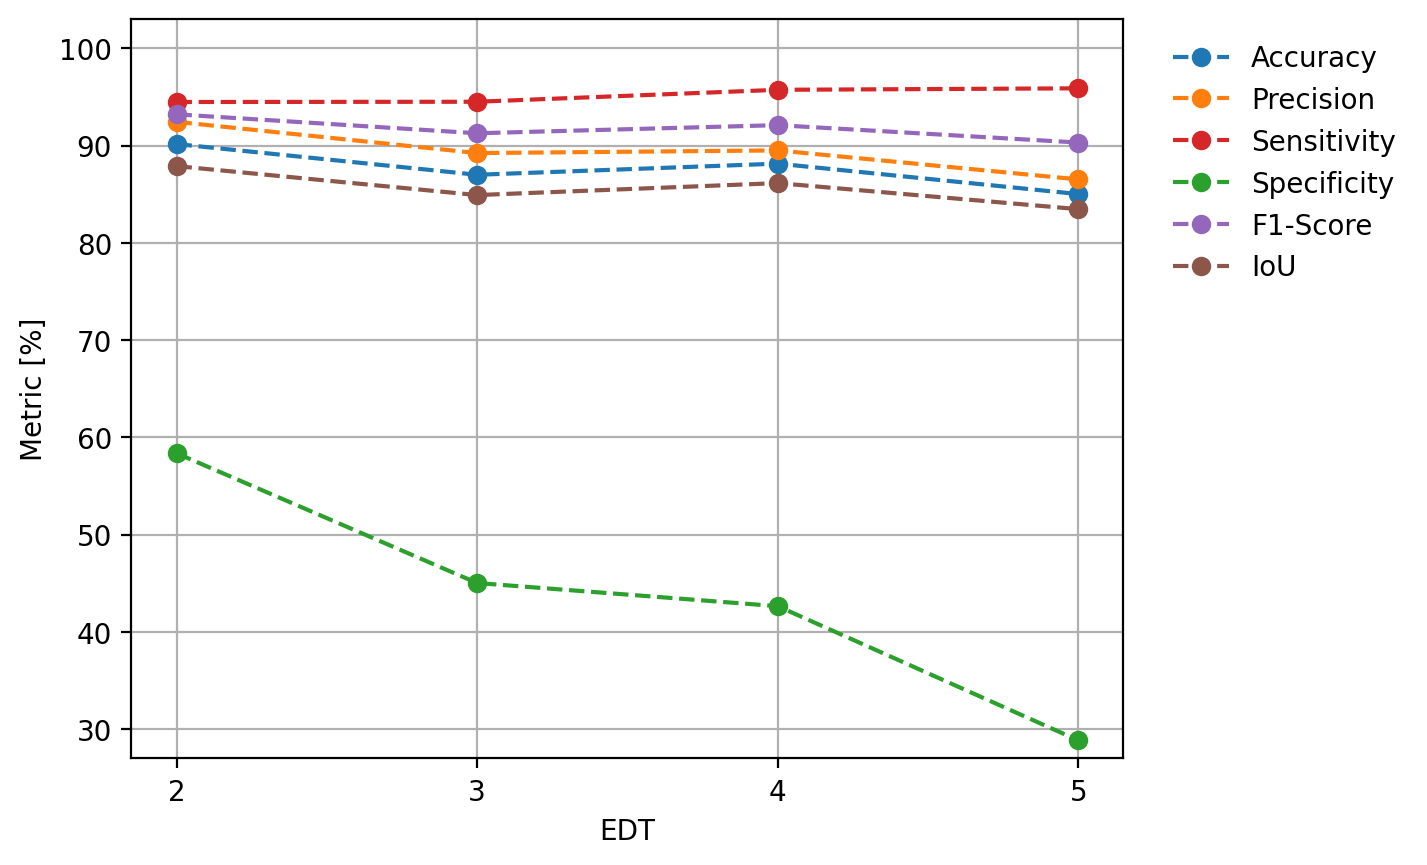

In [9]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,6):
    u = 5
    res = 64
    edtv = i
    extra = 'scaled_squared_binary'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,6), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,6), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,6), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,6), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,6), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,6), iouu, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3,4,5]);
ax.set_ylim(27,103);
plt.savefig('metrics_scaled_sq_bin.png', dpi=300, bbox_inches='tight', transparent=True)

### KDE

In [22]:
names = ['KDE_r64_EDT0_n_5', 'KDE_edtlabel_r64_EDT2_n_5', 'KDE_edtlabel_r64_EDT3_n_5']

for i in np.arange(0,3):
    accuracy =    (np.nanmean(np.load(f'accuracy_{names[i]}.npy')))
    precision =   (np.nanmean(np.load(f'precision_{names[i]}.npy')))
    sensitivity = (np.nanmean(np.load(f'sensitivity_{names[i]}.npy')))
    specificity = (np.nanmean(np.load(f'specificity_{names[i]}.npy')))
    f1score =     (np.nanmean(np.load(f'f1score_{names[i]}.npy')))
    iou =         (np.nanmean(np.load(f'iou_{names[i]}.npy')))

    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

Average accuracy:    84.81 %
Average precision:   84.29 %
Average sensitivity: 99.90 %
Average specificity: 14.47 %
Average f1score:     90.54 %
Average IoU:         84.24 %

Average accuracy:    86.79 %
Average precision:   92.77 %
Average sensitivity: 88.50 %
Average specificity: 68.20 %
Average f1score:     90.25 %
Average IoU:         83.36 %

Average accuracy:    87.31 %
Average precision:   89.69 %
Average sensitivity: 93.81 %
Average specificity: 46.35 %
Average f1score:     91.32 %
Average IoU:         84.98 %



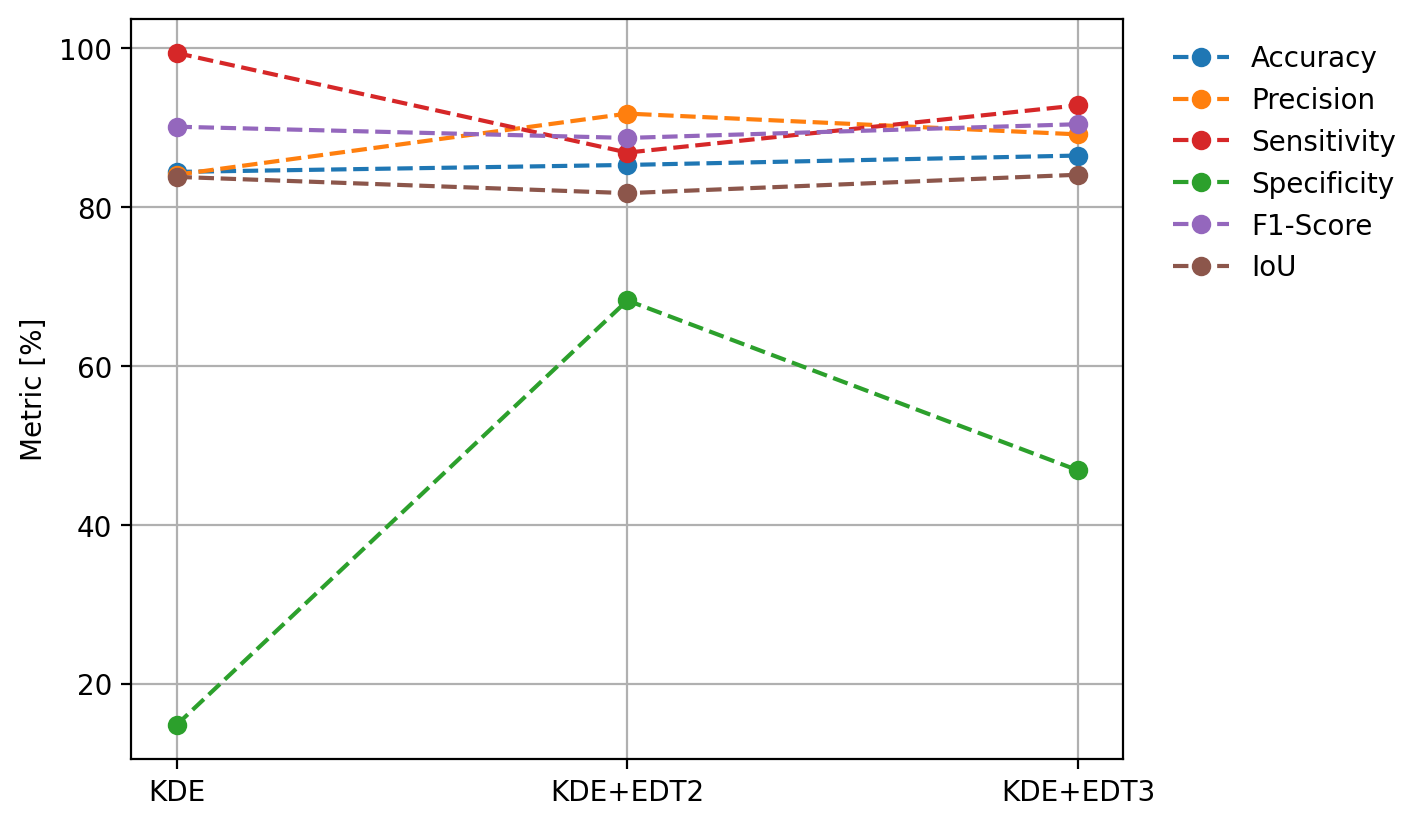

In [21]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

names = ['KDE_r64_EDT0_5', 'KDE_edtlabel_r64_EDT2_5', 'KDE_edtlabel_r64_EDT3_5']

for i in np.arange(0,3):    
    acc.append(np.nanmean(np.load(f'accuracy_{names[i]}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{names[i]}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{names[i]}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{names[i]}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{names[i]}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{names[i]}.npy')))

ax.plot(acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(prec, '--o', color='tab:orange', label='Precision');
ax.plot(sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(spec, '--o', color='tab:green', label='Specificity');
ax.plot(f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(iouu, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
#ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([0,1,2]);
ax.set_xticklabels(['KDE', 'KDE+EDT2', 'KDE+EDT3']);
#ax.set_ylim(28,102);
plt.savefig('metrics_KDE.png', dpi=300, bbox_inches='tight', transparent=True)

### comb scaled

In [110]:
print('combined: scaled')
for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

combined: scaled
EDT = 2
Average accuracy:    93.06 %
Average precision:   92.20 %
Average sensitivity: 98.78 %
Average specificity: 52.95 %
Average f1score:     95.13 %
Average IoU:         91.29 %

EDT = 3
Average accuracy:    88.58 %
Average precision:   88.24 %
Average sensitivity: 98.04 %
Average specificity: 37.66 %
Average f1score:     92.38 %
Average IoU:         86.82 %



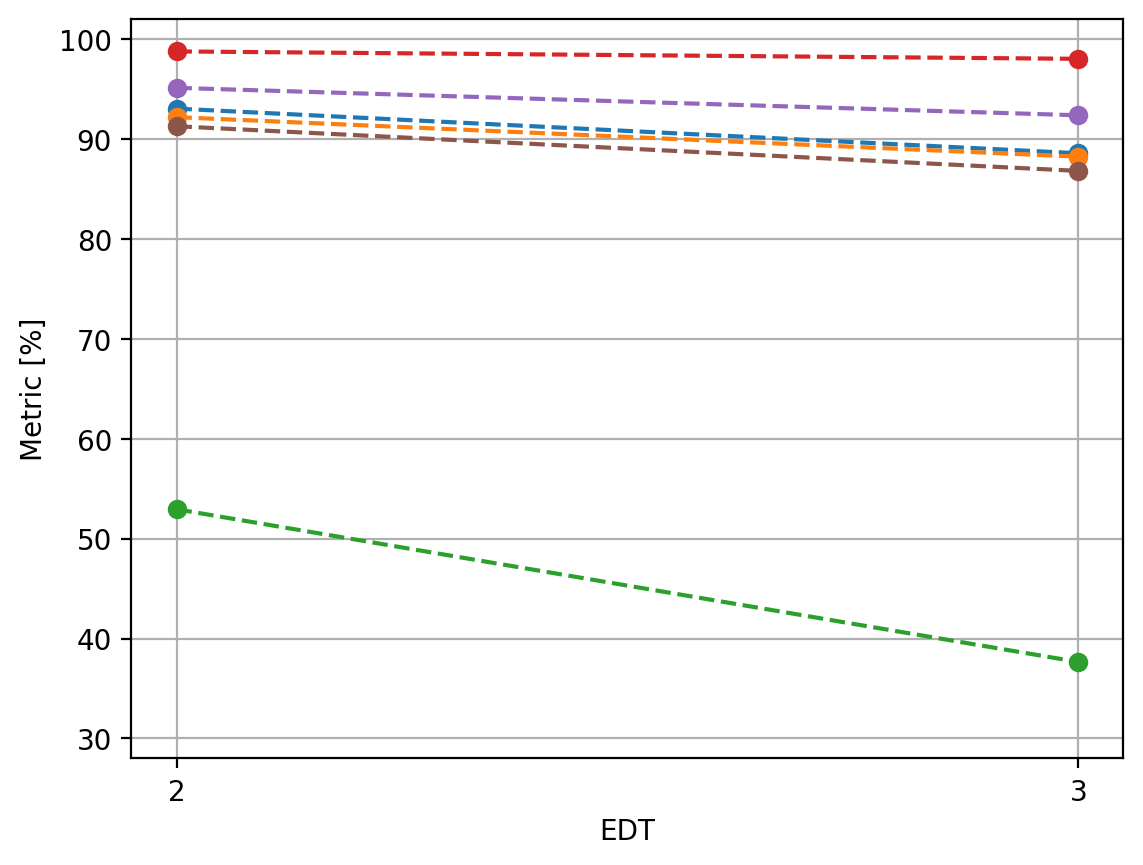

In [111]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,4), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,4), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,4), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,4), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,4), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,4), iouu, '--o', color='tab:brown', label='IoU');
#ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3]);
ax.set_ylim(28,102);
plt.savefig('metrics_comb_scaled.png', dpi=300, bbox_inches='tight', transparent=True)

### comb scaled squared

In [113]:
print('combined: scaled, squared')
for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled_squared'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

combined: scaled, squared
EDT = 2
Average accuracy:    92.57 %
Average precision:   92.27 %
Average sensitivity: 97.80 %
Average specificity: 55.22 %
Average f1score:     94.74 %
Average IoU:         90.58 %

EDT = 3
Average accuracy:    90.39 %
Average precision:   89.79 %
Average sensitivity: 98.13 %
Average specificity: 42.49 %
Average f1score:     93.40 %
Average IoU:         88.45 %



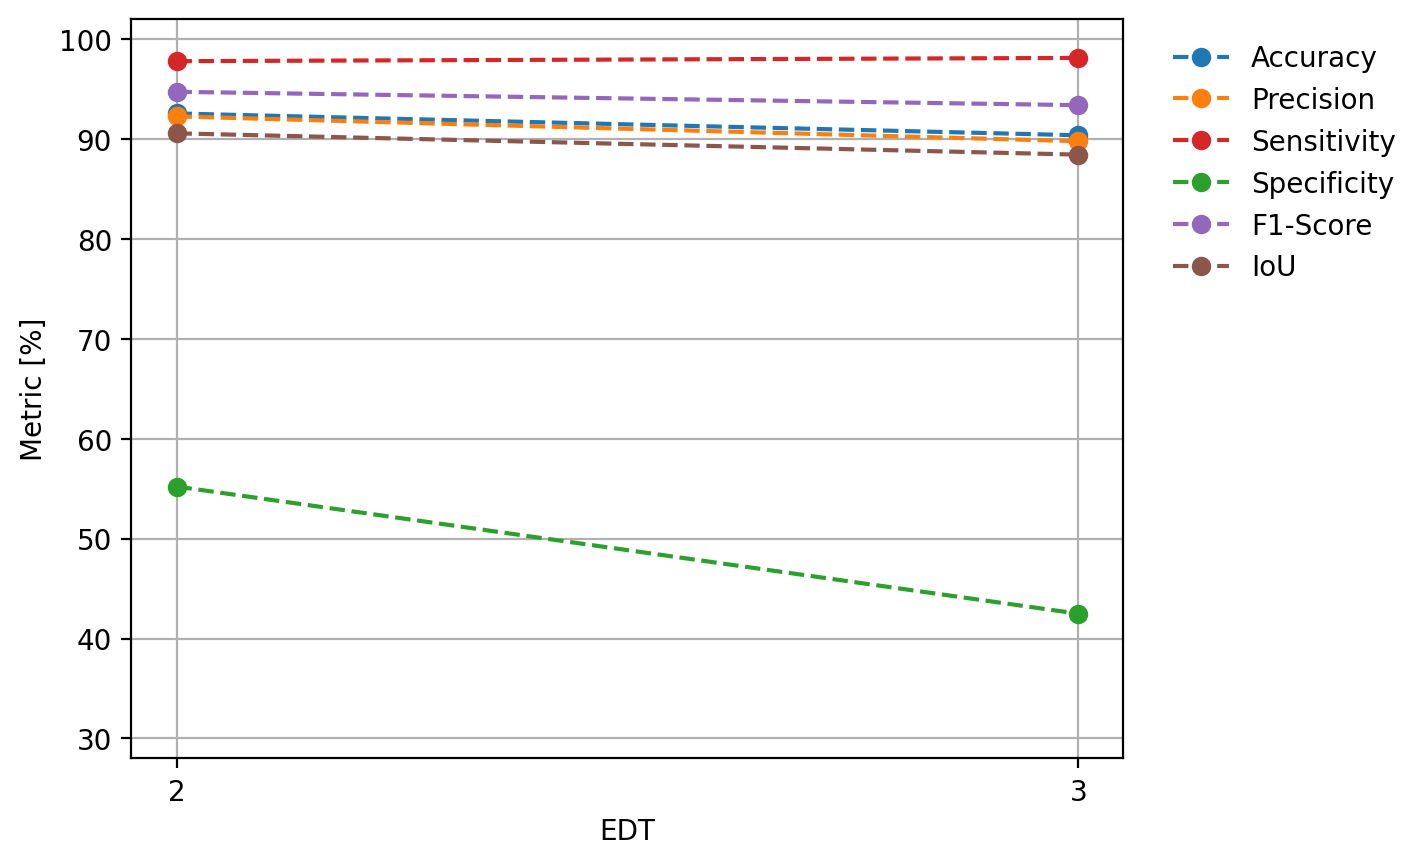

In [115]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled_squared'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,4), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,4), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,4), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,4), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,4), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,4), iouu, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3]);
ax.set_ylim(28,102);
plt.savefig('metrics_comb_scaled_sq.png', dpi=300, bbox_inches='tight', transparent=True)

### comb scaled binary label

In [116]:
print('combined: scaled, closed label')
for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled_binary'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

combined: scaled, closed label
EDT = 2
Average accuracy:    89.94 %
Average precision:   91.86 %
Average sensitivity: 94.99 %
Average specificity: 54.30 %
Average f1score:     93.14 %
Average IoU:         87.74 %

EDT = 3
Average accuracy:    87.30 %
Average precision:   91.80 %
Average sensitivity: 90.70 %
Average specificity: 52.96 %
Average f1score:     90.81 %
Average IoU:         84.21 %



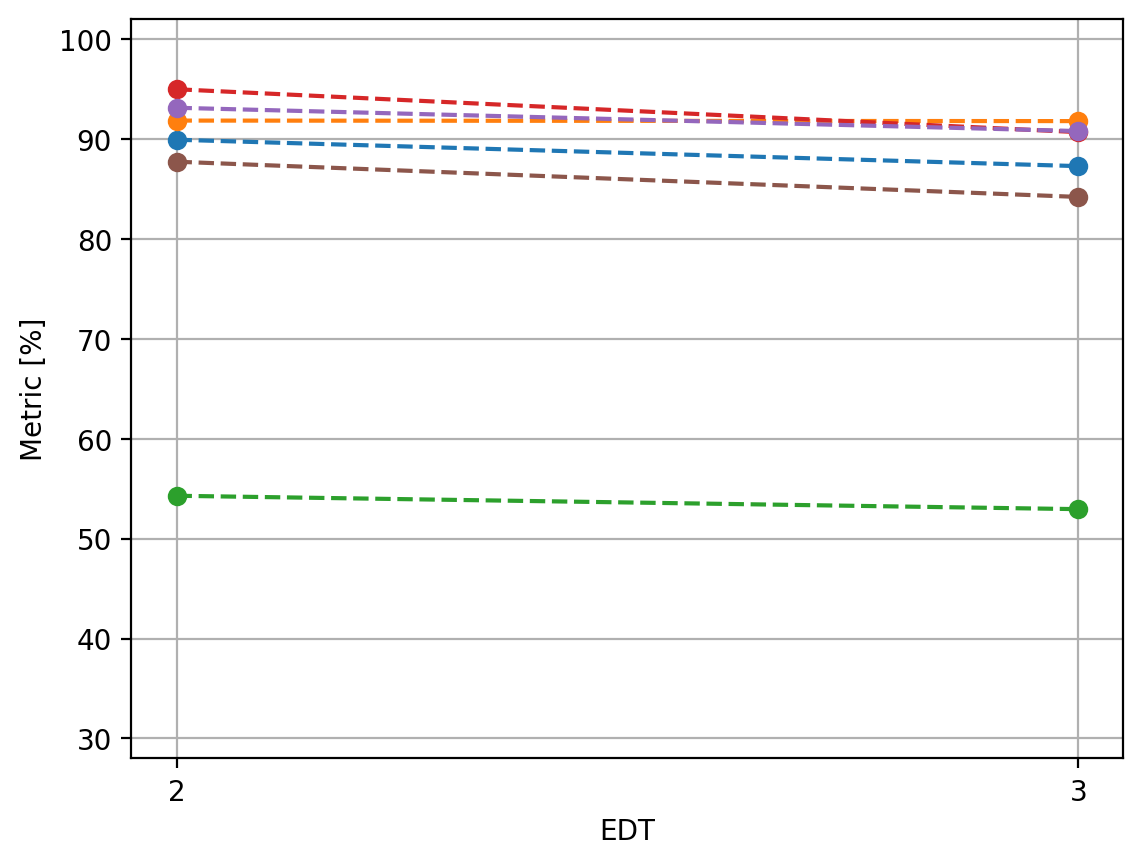

In [117]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled_binary'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,4), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,4), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,4), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,4), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,4), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,4), iouu, '--o', color='tab:brown', label='IoU');
#ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3]);
ax.set_ylim(28,102);
plt.savefig('metrics_comb_scaled_bin.png', dpi=300, bbox_inches='tight', transparent=True)

### comb scaled squared binary label

In [118]:
print('combined: scaled, squared, closed label')
for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled_squared_binary'
    l = 'n'
    
    accuracy = np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    precision = np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    sensitivity = np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')
    specificity = np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    f1score = np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    iou = np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy' )
    print(f'EDT = {i}')
    print(f'Average accuracy:    {np.nanmean(accuracy):.2f} %')
    print(f'Average precision:   {np.nanmean(precision):.2f} %')
    print(f'Average sensitivity: {np.nanmean(sensitivity):.2f} %')
    print(f'Average specificity: {np.nanmean(specificity):.2f} %')
    print(f'Average f1score:     {np.nanmean(f1score):.2f} %')
    print(f'Average IoU:         {np.nanmean(iou):.2f} %\n')

combined: scaled, squared, closed label
EDT = 2
Average accuracy:    88.47 %
Average precision:   90.62 %
Average sensitivity: 94.38 %
Average specificity: 51.22 %
Average f1score:     92.13 %
Average IoU:         86.14 %

EDT = 3
Average accuracy:    87.29 %
Average precision:   88.95 %
Average sensitivity: 95.16 %
Average specificity: 39.83 %
Average f1score:     91.54 %
Average IoU:         85.21 %



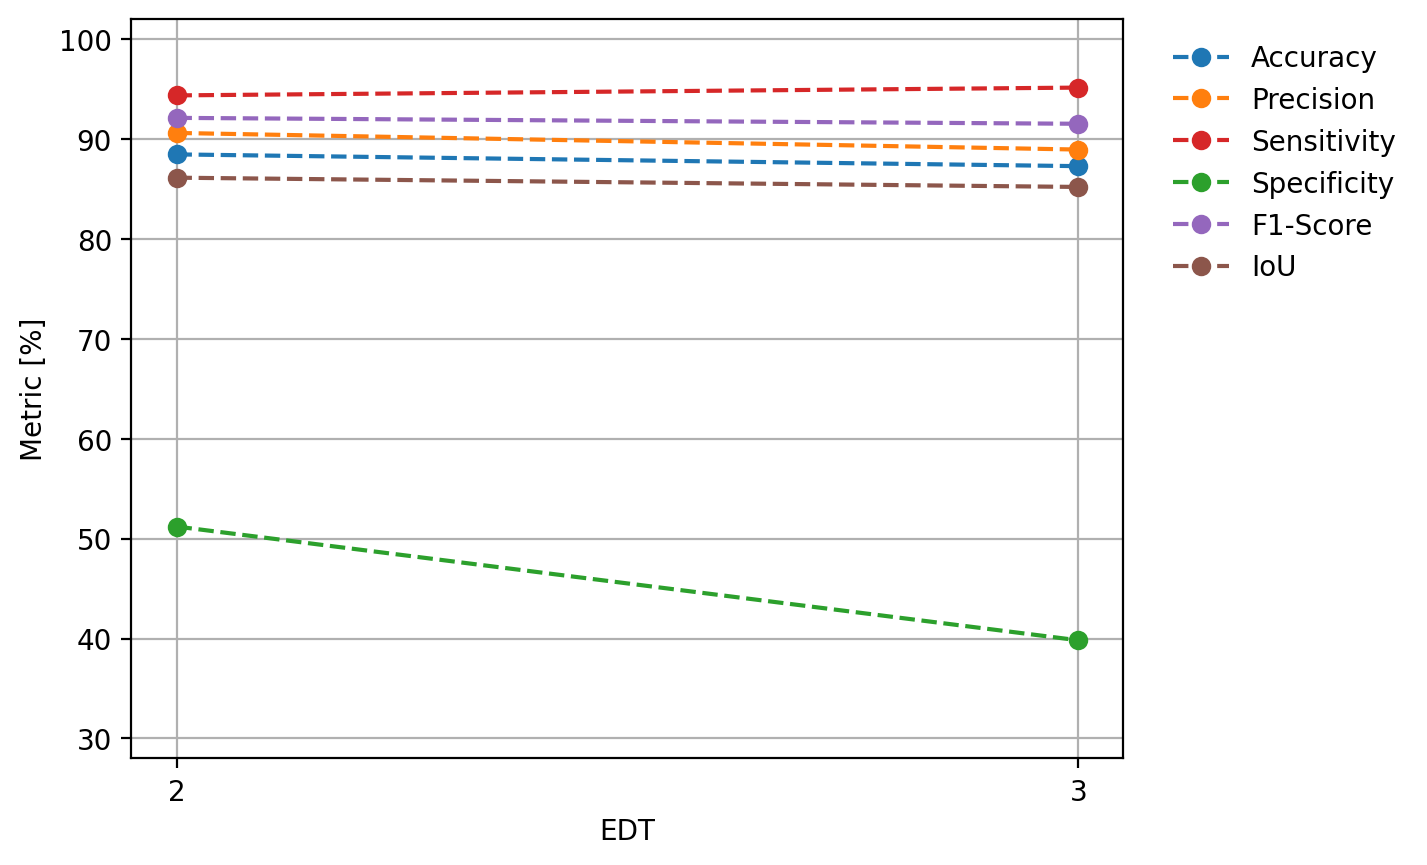

In [119]:
fig, ax = plt.subplots()
fig.set_dpi(200)
acc = []
prec = []
sens = []
spec = []
f1sc = []
iouu = []

for i in np.arange(2,4):
    u = 5
    res = 64
    edtv = i
    extra = 'comb_scaled_squared_binary'
    l = 'n'
    
    acc.append(np.nanmean(np.load(f'accuracy_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    prec.append(np.nanmean(np.load(f'precision_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    sens.append(np.nanmean(np.load(f'sensitivity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    spec.append(np.nanmean(np.load(f'specificity_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    f1sc.append(np.nanmean(np.load(f'f1score_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))
    iouu.append(np.nanmean(np.load(f'iou_{extra}_r{res}_EDT{edtv}_{l}_{u}.npy')))

ax.plot(np.arange(2,4), acc, '--o', color='tab:blue', label=f'Accuracy');
ax.plot(np.arange(2,4), prec, '--o', color='tab:orange', label='Precision');
ax.plot(np.arange(2,4), sens, '--o', color='tab:red', label='Sensitivity');
ax.plot(np.arange(2,4), spec, '--o', color='tab:green', label='Specificity');
ax.plot(np.arange(2,4), f1sc, '--o', color='tab:purple', label='F1-Score');
ax.plot(np.arange(2,4), iouu, '--o', color='tab:brown', label='IoU');
ax.legend(loc='upper right', bbox_to_anchor=(1.3,1), frameon=False);
ax.set_xlabel('EDT')
ax.set_ylabel('Metric [%]');
ax.grid();
ax.set_xticks([2,3]);
ax.set_ylim(28,102);
plt.savefig('metrics_comb_scaled_sq_bin.png', dpi=300, bbox_inches='tight', transparent=True)